In [67]:
import pandas as pd
import numpy as np
n_movies = pd.read_csv('n_movies.csv')
#n_movies.head()

In [68]:
n_movies['genre'] = n_movies['genre'].str.split(', ')

In [135]:
wrangled_n_movies = n_movies.loc[n_movies["rating"].notnull()]
wrangled_n_movies.head()

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"[Action, Comedy, Drama]",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"[Biography, Drama, History]",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"[Crime, Drama]",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"[Drama, Horror, Mystery]",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"[Animation, Action, Adventure]",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [70]:
netflix_titles = pd.read_csv("netflix_titles.csv")
netflix_titles['certificate'] = netflix_titles['rating']
netflix_titles.drop('rating', axis=1, inplace=True)
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,duration,listed_in,description,certificate
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,90 min,Documentaries,"As her father nears the end of his life, filmm...",PG-13
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",TV-MA
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,TV-MA
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",TV-MA
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,TV-MA


In [134]:
merged_data = netflix_titles.merge(wrangled_n_movies, how='inner', on='title') #inner join on title
#print(merged_data)
merged_data.rename(columns={'duration_x':'seasons / movie length', 'duration_y': 'episode / movie length'}, inplace=True)

#get rid of trailing 'min' in episode / movie length column:
merged_data['episode / movie length'] = merged_data['episode / movie length'].replace(r'min$' , regex = True, value='')

#turn values in episode / movie length column to float so we can perform computations on them:
merged_data['episode / movie length'] = merged_data['episode / movie length'].astype(float)

#get rid of trailing 'min' in seasons / movie length column:
merged_data['seasons / movie length'] = merged_data['seasons / movie length'].replace(r'min$' , regex = True, value='')

merged_data.head()
num_observations = len(merged_data)
print(num_observations)

4642


In [72]:
#group by title to get average rating for title - this is needed because individual episodes are listed, 
#so we want the average rating for a show based on individual episode ratings: 
grouped_rating= merged_data.groupby('title')['rating'].mean().to_frame().reset_index()

#renaming this column for clarity:
grouped_rating.rename(columns={'rating':'average rating'}, inplace=True)

#group by title to get average length of the episode / movie - this is needed for the same reason listed above
grouped_episode_duration = merged_data.groupby('title')['episode / movie length'].mean().to_frame().reset_index()

grouped_episode_duration.rename(columns={'episode / movie length':'average episode / movie length'}, inplace=True)

In [73]:
#making a copy of the merged data set to preserve the original one:
merged_data_copy = merged_data.copy()

#merge rating group by with merged data set to get a column with average rating
merge_average_rating = pd.merge(merged_data_copy, grouped_rating)

#merge the new df with the average rating column with average episode duration
merge_with_two_avg_col = pd.merge(merge_average_rating, grouped_episode_duration)

#same as the original merged_data, but now has two columns for average rating and average episode / movie length

In [74]:
#make a copy of the df above with the two average columns to have final cleaned data set
cleaned_data_set = merge_with_two_avg_col.copy()

cleaned_tv_shows = cleaned_data_set[cleaned_data_set["type"] == 'TV Show']

#just movies in clean set
cleaned_movies = cleaned_data_set[cleaned_data_set["type"] == 'Movie']

In [97]:
#extract the month added and add to a column

dates_parsed = merge_with_two_avg_col.copy()
dates_parsed['month added'] = dates_parsed['date_added'].replace(r'[\d\s,]+' , regex = True, value='')

dates_parsed['list # of stars'] = dates_parsed['stars'].apply(eval)

stars_df = dates_parsed['list # of stars'].apply(pd.Series)
stars_df.columns = ['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9',
                    's10','s11','s12','s13','s14','s15','s16','s17','s18']

stars_df["s1"] = stars_df["s1"].replace(r'|' , regex = True, value = np.nan)

stars_df["director?"] = np.where(stars_df['s2'].str.contains("Stars"), 'director', 'no director')
stars_df["s0"] = np.where(stars_df['director?'].str.contains("no"), stars_df["s0"], np.NaN)
stars_df["s2"] = stars_df["s2"].replace(r'Stars:' , regex = True, value = np.nan)

stars_df = stars_df.drop('director?', axis=1)

dates_parsed_and_stars_count = dates_parsed.copy()
dates_parsed_and_stars_count = dates_parsed_and_stars_count.drop('list # of stars', axis=1)
dates_parsed_and_stars_count["star count"] = stars_df.count(axis=1)

dates_parsed_tv = dates_parsed[dates_parsed["type"] == 'TV Show']
dates_parsed_movie = dates_parsed[dates_parsed["type"] == 'Movie']

dates_parsed_and_stars_count_tv = dates_parsed_and_stars_count[dates_parsed_and_stars_count["type"] == 'TV Show']
dates_parsed_and_stars_count_movies = dates_parsed_and_stars_count[dates_parsed_and_stars_count["type"] == 'Movie']

cleaned_tv_shows['genre'] = cleaned_tv_shows['genre'].astype(object)
cleaned_tv_shows_genre = cleaned_tv_shows.explode('genre')

cleaned_movies['genre'] = cleaned_movies['genre'].astype(object)
cleaned_movies_genre = cleaned_movies.explode('genre')

#https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/2138979929.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stars_df = dates_parsed['list # of stars'].apply(pd.Series)


     show_id     type                  title                 director  \
0         s1    Movie   Dick Johnson Is Dead          Kirsten Johnson   
1         s2  TV Show          Blood & Water                      NaN   
2         s2  TV Show          Blood & Water                      NaN   
3         s3  TV Show              Ganglands          Julien Leclercq   
4         s4  TV Show  Jailbirds New Orleans                      NaN   
...      ...      ...                    ...                      ...   
4637   s8776  TV Show        Yeh Meri Family                      NaN   
4638   s8778    Movie              Yes or No  Saratswadee Wongsomphet   
4639   s8789    Movie           You Carry Me               Ivona Juka   
4640   s8803    Movie                 Zodiac            David Fincher   
4641   s8804  TV Show            Zombie Dumb                      NaN   

                                                   cast  \
0                                                   NaN   
1    

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/2138979929.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_tv_shows['genre'] = cleaned_tv_shows['genre'].astype(object)
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/2138979929.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_movies['genre'] = cleaned_movies['genre'].astype(object)


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

691
1071
691


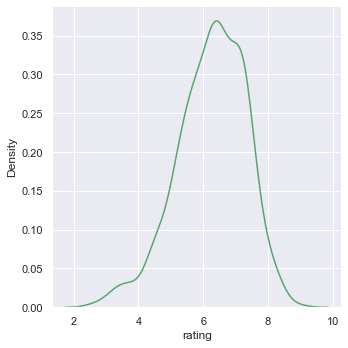

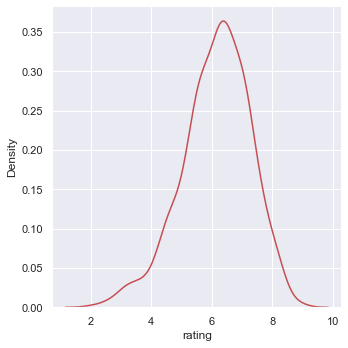

In [203]:
cleaned_movies_country = cleaned_movies.copy()
#cleaned_tv_shows_country['country'] = cleaned_tv_shows_country['country'].astype(object)

us_movies = cleaned_movies_country[cleaned_movies_country['country']=='United States']
not_us_movies = cleaned_movies_country[cleaned_movies_country['country']!='United States']

sns.displot(x='rating', data=us_movies, kind = 'kde', color='g')
sns.displot(x='rating', data=not_us_movies, kind = 'kde', color='r')

print(len(us_movies))
print(len(not_us_movies))
print(len(us_movies))

# print(us_tv_shows)
#sns.relplot(x="star count", y="rating", data=us_tv, color='g')
# sns.relplot(x="star count", y="rating", data=not_us_tv, color='g')
#sns.relplot(x="star count", y="rating", data=dates_parsed_and_stars_count_tv, kind="line", color='g')

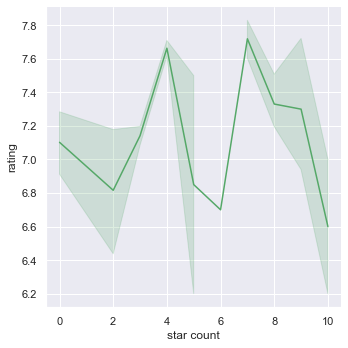

In [100]:
sns.relplot(x="star count", y="rating", data=dates_parsed_and_stars_count_tv, kind="line", color='g')

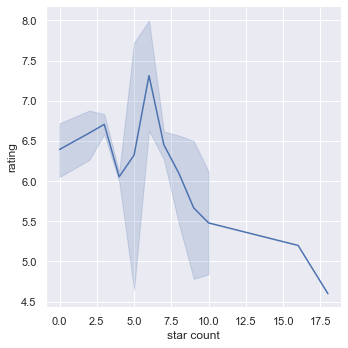

In [101]:
sns.relplot(x="star count", y="rating", data=dates_parsed_and_stars_count_movies, kind="line", color='b')

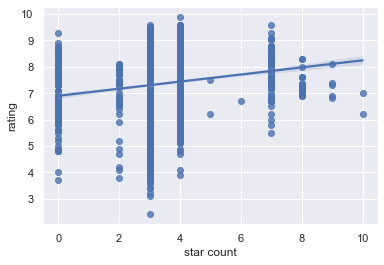

In [102]:
sns.regplot(x='star count', y='rating', data=dates_parsed_and_stars_count_tv);

3              1415
4              1139
Less than 2     170
More than 5     156
Name: star_simplified, dtype: int64


/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/98713016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==3, 3, dates_parsed_and_stars_count_tv['star count'])
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/98713016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star 

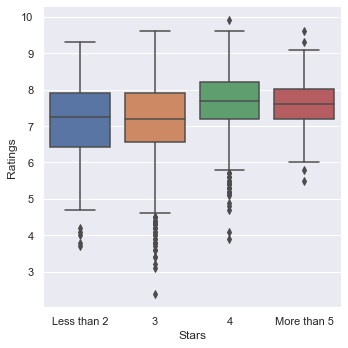

In [206]:
# print(dates_parsed_and_stars_count_tv.value_counts('star count'))
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==3, 3, dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==4, 4, dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']>=5, 'More than 5', dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']<=2, 'Less than 2', dates_parsed_and_stars_count_tv['star_simplified'])


print(dates_parsed_and_stars_count_tv['star_simplified'].value_counts())
graph = sns.catplot(data=dates_parsed_and_stars_count_tv, 
            x="star_simplified", 
            y="rating", 
            kind="box", 
            order=['Less than 2', '3', '4', 'More than 5'])
graph.set_axis_labels('Stars', 'Ratings')

4              1286
3               212
More than 5     192
Less than 2      72
Name: star_simplified, dtype: int64


/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/2341646907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==3, 3, dates_parsed_and_stars_count_movies['star count'])
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/2341646907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_s

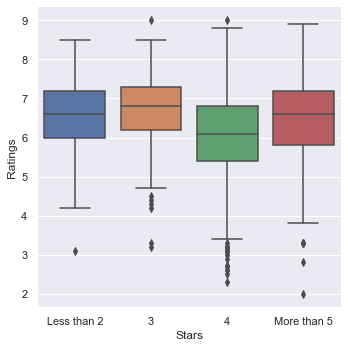

In [207]:
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==3, 3, dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==4, 4, dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']>=5, 'More than 5', dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']<=2, 'Less than 2', dates_parsed_and_stars_count_movies['star_simplified'])


print(dates_parsed_and_stars_count_movies['star_simplified'].value_counts())
graph = sns.catplot(data=dates_parsed_and_stars_count_movies, 
            x="star_simplified", 
            y="rating", 
            kind="box", 
            order=['Less than 2', '3', '4', 'More than 5'])
graph.set_axis_labels('Stars', 'Ratings')

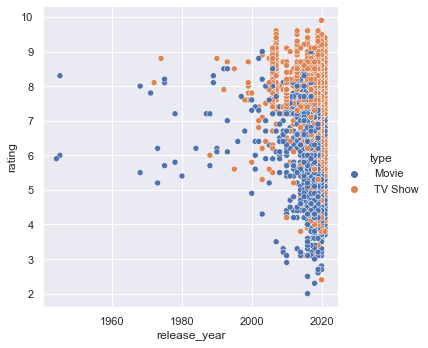

In [105]:
sns.set_theme()
sns.relplot(x='release_year', y='rating', hue="type", data=cleaned_data_set);

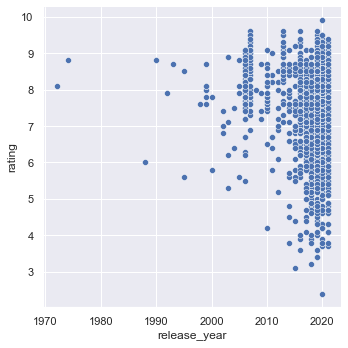

In [106]:
sns.relplot(x='release_year', y='rating', data=cleaned_tv_shows, color='b')

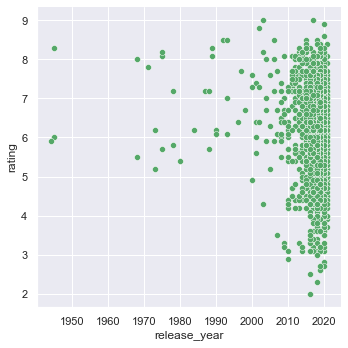

In [107]:
sns.relplot(x='release_year', y='rating', data=cleaned_movies, color='g')

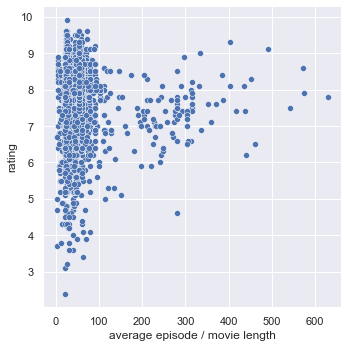

In [108]:
sns.relplot(x='average episode / movie length', y='rating', data=cleaned_tv_shows, color='b')

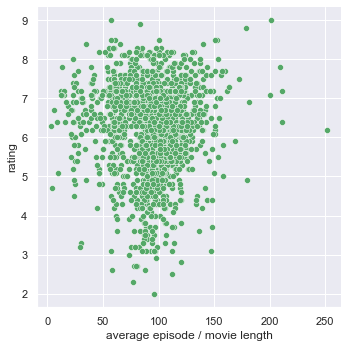

In [109]:
sns.relplot(x='average episode / movie length', y='rating', data=cleaned_movies, color='g')

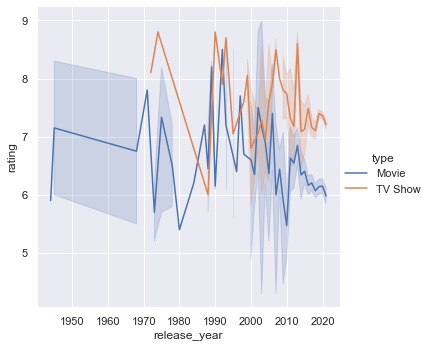

In [110]:
sns.relplot(x="release_year", y="rating", data=cleaned_data_set, hue='type', kind="line")

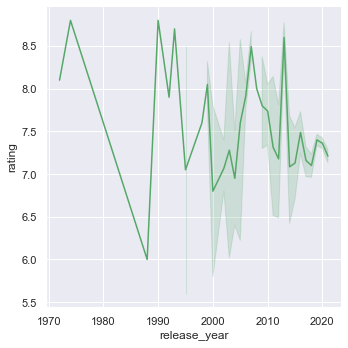

In [111]:
sns.relplot(x="release_year", y="rating", data=cleaned_tv_shows, kind="line", color='g')

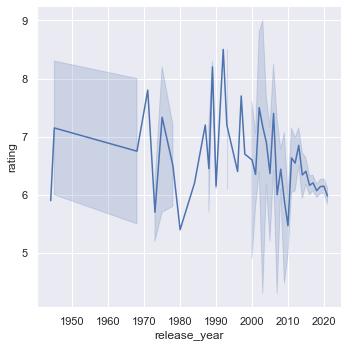

In [112]:
sns.relplot(x="release_year", y="rating", data=cleaned_movies, kind="line", color='b')

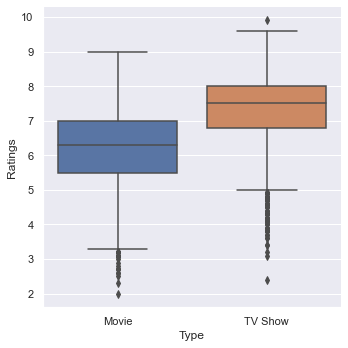

In [208]:
graph = sns.catplot(data=cleaned_data_set, x="type", y="rating", kind="box")
graph.set_axis_labels('Type', 'Ratings')

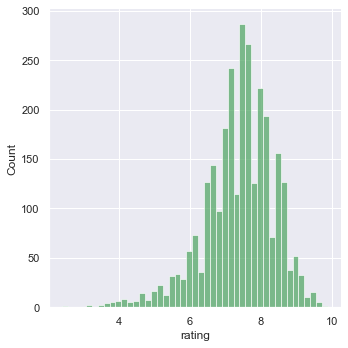

In [114]:
sns.displot(data=cleaned_tv_shows, x="rating", color='g')

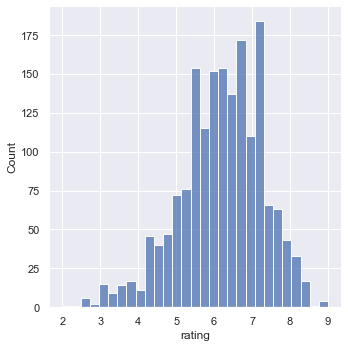

In [115]:
graph = sns.displot(data=cleaned_movies, x="rating")

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/3142344646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_tv["month added"] = pd.Categorical(dates_parsed_tv["month added"], months)


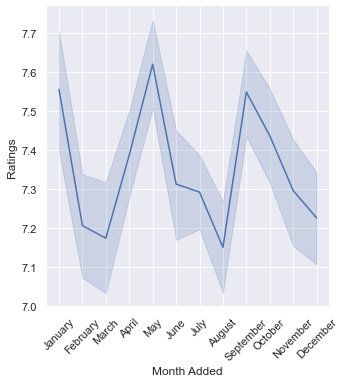

In [124]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

dates_parsed_tv["month added"] = pd.Categorical(dates_parsed_tv["month added"], months)

graph = sns.relplot(x="month added", y="rating", data=dates_parsed_tv, kind="line", color='b')# col_order=months)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Month Added', 'Ratings')

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_1137/3394915951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_movie["month added"] = pd.Categorical(dates_parsed_movie["month added"], months)


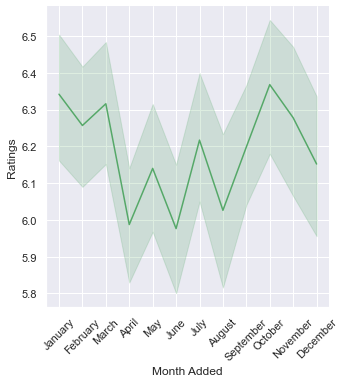

In [125]:
dates_parsed_movie["month added"] = pd.Categorical(dates_parsed_movie["month added"], months)

graph = sns.relplot(x="month added", y="rating", data=dates_parsed_movie, kind="line", color='g')
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Month Added', 'Ratings')

In [51]:
proper_tv_ratings_mask = ((cleaned_tv_shows['certificate_y'] == 'TV-14') | 
(cleaned_tv_shows['certificate_y'] == 'TV-MA') |
(cleaned_tv_shows['certificate_y'] == 'TV-PG') | 
(cleaned_tv_shows['certificate_y'] == 'TV-Y7') |
(cleaned_tv_shows['certificate_y'] == 'TV-Y') |
(cleaned_tv_shows['certificate_y'] == 'TV-Y7-FV') |
(cleaned_tv_shows['certificate_y'] == 'TV-G'))

proper_tv_ratings = cleaned_tv_shows[proper_tv_ratings_mask]


proper_movie_ratings_mask = ((cleaned_movies['certificate_y'] == 'PG-13') |
                             (cleaned_movies['certificate_y'] == 'PG') |
                             (cleaned_movies['certificate_y'] == 'R') |
                            (cleaned_movies['certificate_y'] == 'G') |
                            (cleaned_movies['certificate_y'] == 'NC-17'))
proper_movie_ratings = cleaned_movies[proper_movie_ratings_mask]


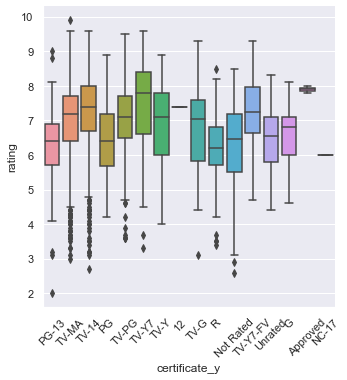

In [52]:
graph = sns.catplot(data=dates_parsed, x="certificate_y", y="rating", kind="box")
graph.set_xticklabels(rotation=45)

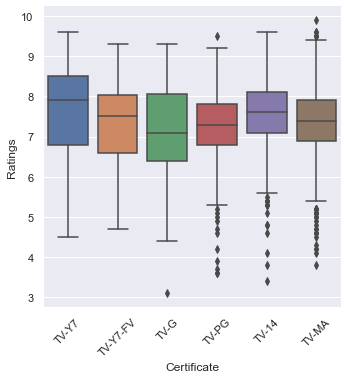

In [127]:
ordered_tv_certificates = ['TV-Y7','TV-Y7-FV','TV-G','TV-PG','TV-14','TV-MA']
graph = sns.catplot(data=proper_tv_ratings, x="certificate_y", y="rating", kind="box", order=ordered_tv_certificates)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Certificate', 'Ratings')

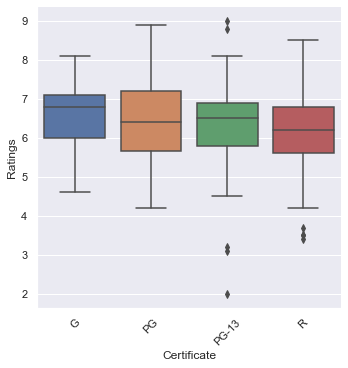

In [126]:
ordered_certificates = ['G','PG','PG-13','R']
graph = sns.catplot(data=proper_movie_ratings, x="certificate_y", y="rating", kind="box", order=ordered_certificates)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Certificate', 'Ratings')

In [55]:

#rating_x is maturity rating, which is already listed as certificate. drop rating_x bc of redundancy?
    #combined them certificate
#rating_y is imdb rating
#before merge, if we wanted to preserve those titles listed in netflix_titles without an indication of tv or movie, 
#we could use a regex from certificate
    #BUT, the merged data just based on title still has 4600+ rows, so not necessary

#1) Group by title and then take average imdb rating to account for different episodes listed
    #could also do the same to get the average episode length
#2) duration_x either gives movie length or it gives number of seasons (for tv show) 
    #duration_y gives movie length or length of a single episode
    #if we wanted to calculate some figure that depends on content length and imdb rating, we could do a visualization for tv shows
    #either dependent on number of seasons or average episode length in the group_by indicated in #1)
    

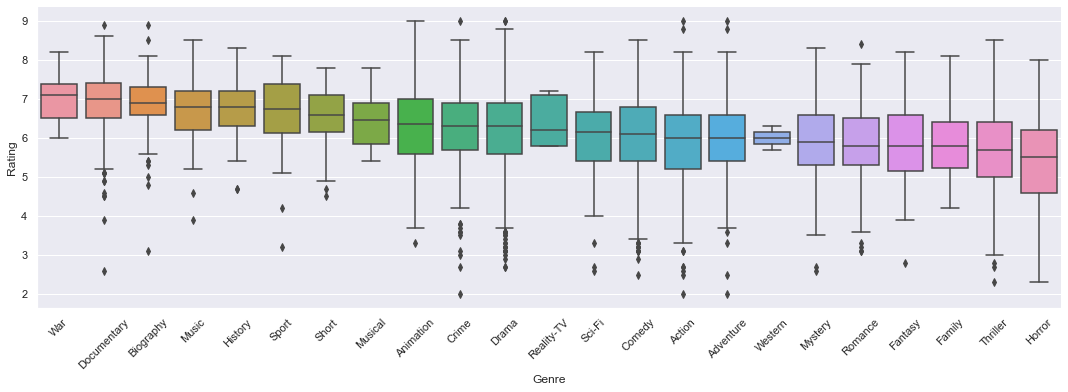

In [132]:
# top_ordered = cleaned_movies_genre.groupby('genre')['rating'].median().sort_values(ascending=False).nlargest().index.values
# bottom_ordered = np.flip(cleaned_movies_genre.groupby('genre')['rating'].median().sort_values(ascending=False).nsmallest().index.values)
# top_bottom = np.append(top_ordered, bottom_ordered)

order_low_high = cleaned_movies_genre.groupby('genre')['rating'].median().sort_values(ascending=False).index.values
graph = sns.catplot(data=cleaned_movies_genre, x='genre', y='rating', kind="box", order=order_low_high[1:], aspect=3)
#graph = sns.catplot(data=cleaned_movies_genre, x='genre', y='rating', kind="box", order=top_bottom, aspect=2)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Genre', 'Rating')

['News' 'Musical' 'War' 'Western' 'History' 'Thriller' 'Sci-Fi' 'Short'
 'Reality-TV' 'Game-Show']


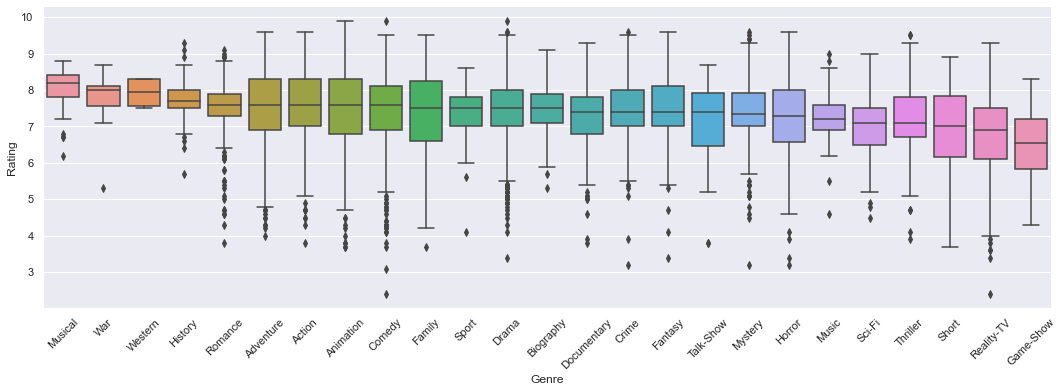

In [131]:
# top_ordered_tv = cleaned_tv_shows_genre.groupby('genre')['rating'].median().sort_values(ascending=False).nlargest().index.values
# bottom_ordered_tv = np.flip(cleaned_tv_shows_genre.groupby('genre')['rating'].median().sort_values(ascending=False).nsmallest().index.values)
# top_bottom_tv = np.append(top_ordered_tv, bottom_ordered_tv)

order_low_high = cleaned_tv_shows_genre.groupby('genre')['rating'].median().sort_values(ascending=False).index.values
graph = sns.catplot(data=cleaned_tv_shows_genre, x='genre', y='rating', kind="box", order=order_low_high[1:], aspect=3)
#graph = sns.catplot(data=cleaned_tv_shows_genre, x='genre', y='rating', kind="box", order=top_bottom_tv, aspect=2)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Genre', 'Rating')